# Локализация. Упражнения

В этих упражнениях вам предлагается реализовать простые алгоритмы локализации роботов. На лекции, помимо фильтра частиц, были упомянуты методы триангуляции и альфа-бета фильтр. Давайте их реализуем: обе реализации должны быть сделаны в виде класса, у которого должен быть метод update. Метод update принимает на вход измеренения с камеры о положении ориентиров в сосбтвенной системе координат робота.

В качестве ориентиров будем использовать координаты стоек ворот. Для удобства будем пользоваться упрощенным вариантом, при котором ворота разных цветов. В словаре храняться положения стоек в глобальной системе координат (точка (0, 0) нахождится в центре поля)

In [1]:
landmarks = {
    "blue_posts": [
        [ -4.5, -1.0], [ -4.5, 1.0]
    ],
    "yellow_posts":[
        [ 4.5, -1.0], [ 4.5, 1.0]
    ]
}

Пример данных, которые могут поступать в модуль на одном шаге всей системы. Данные во втором словаре – это данные одометрии с собвственной информацией робота о перемещении за один шаг системы. Для проверки работы придумайте и запишите набор данных с такой же структурой. 

In [2]:
observations = {"yellow_posts":[[4.45, -0.99],[4.49, 1.09]], "blue_posts":[]}
shift = {'shift_x':0.0, 'shift_y':0.01, 'shift_angle':-0.4}

### 1) Реализовать локализацию триангуляцией (3 балл)
    

In [3]:
class Robott:
  def __init__(self, x=0, y =0, yaw=0):
    self.x = x
    self.y = y
    self.yaw = yaw
  def set_coord(self, x, y, yaw):
    self.x = float(x)
    self.y = float(y)
    self.yaw = float(yaw)
  def move(self, x,y,yaw):
    orientation = self.yaw + float(-yaw)
    if orientation < 0:
      orientation += math.pi *2
    self.yaw =  orientation % (math.pi *2)
    self.x += x*math.cos(self.yaw)
    self.y += y*math.sin(self.yaw)

class localization_triangulation:
    
    def __init__(self, x_start, y_start):
       
        self.x = x_start
        self.y = y_start
    
    def update(self, distances):

        #видны желтые стойки ворот
        if distances["blue_posts"] == []:
            r1 = distances["yellow_posts"][0]
            r2 = distances["yellow_posts"][1]
            l = landmarks["yellow_posts"][1][1] - landmarks["yellow_posts"][0][1]
            p = (r1 + r2 + l) / 2
            s = (p*(p-r1)*(p-r2)*(p-l))**(1/2)
            h = 2*s/l
            self.y = landmarks["yellow_posts"][0][0] - h
            if r2**2 > l**2 + r1**2:
                l1 = (r1**2 - h**2)**(1/2)
                self.x = landmarks["yellow_posts"][0][1] - l1
            if r1**2 > l**2 + r2**2:
                l2 = (r2**2 - h**2)**(1/2)
                self.x = landmarks["yellow_posts"][1][1] + l2
            else:
                l1 = (r1**2 - h**2)**(1/2)
                self.x = landmarks["yellow_posts"][0][1] + l1
        #видны синие стойки ворот
        else:
            r1 = distances["blue_posts"][0]
            r2 = distances["blue_posts"][1]
            l = landmarks["blue_posts"][1][1] - landmarks["blue_posts"][0][1]
            p = (r1 + r2 + l) / 2
            s = (p*(p-r1)*(p-r2)*(p-l))**(1/2)
            h = 2*s/l
            self.y = landmarks["blue_posts"][0][0] + h
            if r2**2 > l**2 + r1**2:
                l1 = (r1**2 - h**2)**(1/2)
                self.x = landmarks["blue_posts"][0][1] - l1
            if r1**2 > l**2 + r2**2:
                l2 = (r2**2 - h**2)**(1/2)
                self.x = landmarks["blue_posts"][1][1] + l2
            else:
                l1 = (r1**2 - h**2)**(1/2)
                self.x = landmarks["blue_posts"][0][1] + l1

# Сделаем проверку

In [4]:
# Преобразует позицию робота в расстояния до ворот
def positions2distances(positions):
    dst_y1 = ((positions["y"] - landmarks["yellow_posts"][0][0])**2 + (positions["x"] - landmarks["yellow_posts"][0][1])**2)**(1/2)
    dst_y2 = ((positions["y"] - landmarks["yellow_posts"][1][0])**2 + (positions["x"] - landmarks["yellow_posts"][1][1])**2)**(1/2)

    dst_b1 = ((positions["y"] - landmarks["blue_posts"][0][0])**2 + (positions["x"] - landmarks["blue_posts"][0][1])**2)**(1/2)
    dst_b2 = ((positions["y"] - landmarks["blue_posts"][1][0])**2 + (positions["x"] - landmarks["blue_posts"][1][1])**2)**(1/2)
    
    return {"yellow_posts": [dst_y1, dst_y2], "blue_posts": [dst_b1, dst_b2]}

Robot = localization_triangulation(0, 0)

positions1 = {"x": 1, "y": 1}
distances1 = positions2distances(positions1)
distances1["yellow_posts"] = []
Robot.update(distances1)
print(Robot.x, Robot.y)

positions2 = {"x": 2, "y": 2}
distances2 = positions2distances(positions2)
distances2["blue_posts"] = []
Robot.update(distances2)
print(Robot.x, Robot.y)

positions3 = {"x": 1, "y": 5}
distances3 = positions2distances(positions3)
distances3["yellow_posts"] = []
Robot.update(distances3)
print(Robot.x, Robot.y)

1.0 1.0
1.9999999999999973 1.9999999999999991
0.9999999999999574 5.000000000000009


### 2) Дополнить предыдущий пункт до альфа-бета фильтра (5 балла)

In [5]:
class localization_alphabeta:
    
    def __init__(self, x_start, y_start, alpha, beta):
       
        self.x = x_start
        self.y = y_start

        self.local_tri =  localization_triangulation(x_start, y_start)

        self.alpha = alpha
        self.beta = beta
    
    def update(self, distances, shift):
        
        self.local_tri.update(distances)
        x_tri = self.local_tri.x
        y_tri = self.local_tri.y

        x_odo = self.x + shift["x"]
        y_odo = self.y + shift["y"]

        self.x = x_tri*self.alpha + x_odo*self.beta
        self.y = y_tri*self.alpha + y_odo*self.beta

### 3) *Дополнительно* Добавьте визуализацию вида сверху  (2 балла)

Например на OpenCV или Matplotlib, например так как было в семинаре, чтобы можно было удобно посмотреть на работу модуля.


In [6]:
class Field:
  def __init__(self, field_param):
    self.field = field_param
    self.w_width = field_param['main_rectangle'][0][0]
    self.w_length = field_param['main_rectangle'][0][1]
    
parfield = {
    "circles": [
                [0.0, 0.0,1.0]
    ], 
    "lines":[
             [[-3.0,3.0], [0.0, 0.0]]
    ], 
    "points":[
              [0, 0]
    ],
    "main_rectangle":[
                      [6.0, 9.0]
    ], 
    "rectangles":[
                  [[-1, -4.5], 2,1], [[-1, 3.5],2,1]
    ]
}

import math
import matplotlib.pylab as plt
field = Field(parfield)
def visualization(robot, pr, factor = 7):
  plt.figure("robot ", figsize=(field.w_width, field.w_length))
  plt.title('particle filter')

  grid = [-field.w_width/2, field.w_width/2, -field.w_length/2, field.w_length/2]
  ax = plt.axis(grid)
  for el in field.field:
    if el == 'circles':
      for circle in field.field['circles']:
        plot_circle = plt.Circle((circle[0], circle[1]), circle[2], linewidth=2, fill =False, edgecolor = 'r')
        plt.gca().add_patch(plot_circle)
    if el == 'lines':
      for line in field.field['lines']:
        plot_line = plt.Line2D(line[0], line[1], linewidth = 2, linestyle = '-', color = '#330000')
        plt.gca().add_line(plot_line)
    if el == 'rectangles':
      for rectangle in field.field['rectangles']:
        rect = plt.Rectangle(rectangle[0], rectangle[1],rectangle[2], linewidth = 2, linestyle = '-', fill = False)
        plt.gca().add_patch(rect)
    if pr != False:
      circle = plt.Circle((robot.y, robot.x), 1./factor, facecolor='#FF66E9', edgecolor='#FF66E9')
      plt.gca().add_patch(circle)

      arrow = plt.Arrow(robot.y, robot.x, 3*math.sin(robot.yaw)/factor, 3*math.cos(robot.yaw)/factor, width=1/factor)
      plt.gca().add_patch(arrow)

  for lm in landmarks:
    for lms in landmarks[lm]:
      if lm == "yellow_posts":
        circle = plt.Circle((lms[0], lms[1]), 1./factor, facecolor ='#ffff00', edgecolor = '#330000')
        plt.gca().add_patch(circle)
      else:
        circle = plt.Circle((lms[0], lms[1]), 1./factor, facecolor = '#060C73', edgecolor = '#330000')
        plt.gca().add_patch(circle)

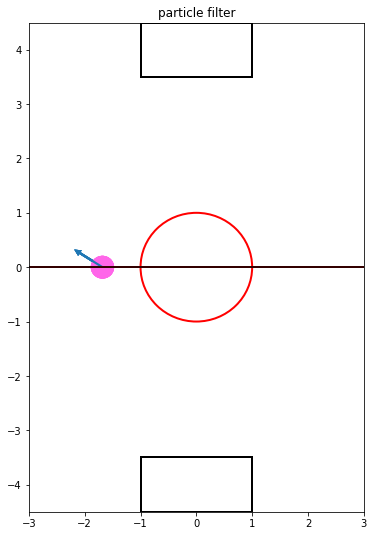

In [13]:
r = Robott()
r.move(0,2,1)
visualization(r, True, 5)